# Assignment2


This assignment focuses on depth estimation, photometric stereo and Robotic Vision LLM. You are required to complete 3 tasks, along with the RV-LLM component. The grading is as follows: RV Task 1 (10%), RV Task 2 (10%), and RV-LLM (10%).


Please submit a PDF report that thoroughly documents your process and includes all output visualizations. Additionally, provide a Jupyter Notebook containing all the code and visualizations.


## Marking Criteria:
- Qualitative and quantitative analysis.
- Justification and documentation of design choices.
- Visualization and quantitative evaluation of results.
- Demonstration of critical thinking and problem-solving skills.

# Task1: Depth Estimation Comparison  

In this task, you will compare different methods for estimating depth and analyze their performance across varying geometry and materials. You have been provided with **three input images**. Using the methods listed below, estimate depth information and evaluate the effectiveness of each approach.  

## Depth Estimation Methods  

- **Method 1: Stereo Depth**  
  Apply stereo reconstruction to extract depth information from the provided images.  

- **Method 2: Monodepth**  
  Use monocular depth estimation with the **Depth Anything V2 Model**:  
  [Depth Anything V2](https://huggingface.co/spaces/depth-anything/Depth-Anything-V2).  

- **Method 3: Lidar**  
  Analyze a set of **simulated LIDAR scans** provided for the task.  

## Evaluation Criteria  

Evaluate the effectiveness of each method using both **quantitative** and **qualitative** assessments.  

### Qualitative Evaluation  
- Reproject the image based on the estimated depth and visualize it from alternative viewpoints.  
- Generate a visual L1 difference map comparing the estimated depth to the ground truth.  

### Quantitative Evaluation  
- Provide numerical comparisons of accuracy, such as error metrics or statistical analyses.  

## Discussion  
Summarize your findings, highlighting the strengths and limitations of each method under different conditions.  


In [160]:
def getX(line, y):
    x = -(line[1]*y + line[2])/line[0]
    return x

def makeImageSizeSame(imgs):
    images = imgs.copy()
    sizes = []
    for image in images:
        x, y, ch = image.shape
        sizes.append([x, y, ch])

    sizes = np.array(sizes)
    x_target, y_target, _ = np.max(sizes, axis = 0)
    
    images_resized = []

    for i, image in enumerate(images):
        image_resized = np.zeros((x_target, y_target, sizes[i, 2]), np.uint8)
        image_resized[0:sizes[i, 0], 0:sizes[i, 1], 0:sizes[i, 2]] = image
        images_resized.append(image_resized)

    return images_resized

def displaySaveImage(image, file_name =  None):
    cv2.imshow("image", image)
    cv2.waitKey()
    if file_name is not None:
        cv2.imwrite(file_name, image)
    cv2.destroyAllWindows()
    
def getEpipolarLines(set1, set2, F, image0, image1, rectified = False):
    # set1, set2 = matched_pairs_inliers[:,0:2], matched_pairs_inliers[:,2:4]
    lines1, lines2 = [], []
    img_epi1 = image0.copy()
    img_epi2 = image1.copy()

    for i in range(set1.shape[0]):
        x1 = np.array([set1[i,0], set1[i,1], 1]).reshape(3,1)
        x2 = np.array([set2[i,0], set2[i,1], 1]).reshape(3,1)

        line2 = np.dot(F, x1)
        lines2.append(line2)

        line1 = np.dot(F.T, x2)
        lines1.append(line1)
    
        if not rectified:
            y2_min = 0
            y2_max = image1.shape[0]
            x2_min = getX(line2, y2_min)
            x2_max = getX(line2, y2_max)

            y1_min = 0
            y1_max = image0.shape[0]
            x1_min = getX(line1, y1_min)
            x1_max = getX(line1, y1_max)
        else:
            x2_min = 0
            x2_max = image1.shape[1] - 1
            y2_min = -line2[2]/line2[1]
            y2_max = -line2[2]/line2[1]

            x1_min = 0
            x1_max = image0.shape[1] -1
            y1_min = -line1[2]/line1[1]
            y1_max = -line1[2]/line1[1]



        cv2.circle(img_epi2, (int(set2[i,0]),int(set2[i,1])), 10, (0,0,255), -1)
        img_epi2 = cv2.line(img_epi2, (int(x2_min), int(y2_min)), (int(x2_max), int(y2_max)), (255, 0, int(i*2.55)), 2)
    

        cv2.circle(img_epi1, (int(set1[i,0]),int(set1[i,1])), 10, (0,0,255), -1)
        img_epi1 = cv2.line(img_epi1, (int(x1_min), int(y1_min)), (int(x1_max), int(y1_max)), (255, 0, int(i*2.55)), 2)

    image_1, image_2 = makeImageSizeSame([img_epi1, img_epi2])
    concat = np.concatenate((image_1, image_2), axis = 1)
    concat = cv2.resize(concat, (1920, 660))
    # cv2.imshow("a", concat)
    plt.imshow(concat[:, :, ::-1])
    cv2.imwrite('concat.png', concat)
    # cv2.waitKey()
    # cv2.destroyAllWindows()
    return lines1, lines2

基線距離 B: 1.000000 米
Fundametal: [[ 0.09149491  0.28907518 -0.20521676]
 [ 2.95817245 -0.07899741 -9.53707583]
 [ 0.89483962  9.87387121  0.16265117]]
Estimated H1 and H2 as [[ 1.31587663e-02 -2.56326573e-03 -3.10348387e-01]
 [-9.46562379e-04  1.60380885e-02  5.45801492e-01]
 [-7.98240560e-06  1.95858446e-07  2.01685365e-02]] [[ 1.02919633e+00 -2.26630015e-02 -1.07188970e+01]
 [ 3.67341006e-02  9.99433525e-01 -2.18705177e+01]
 [ 4.90644722e-05 -1.08040437e-06  9.70885438e-01]]
0.1
6000.0


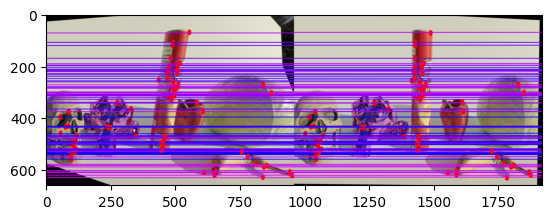

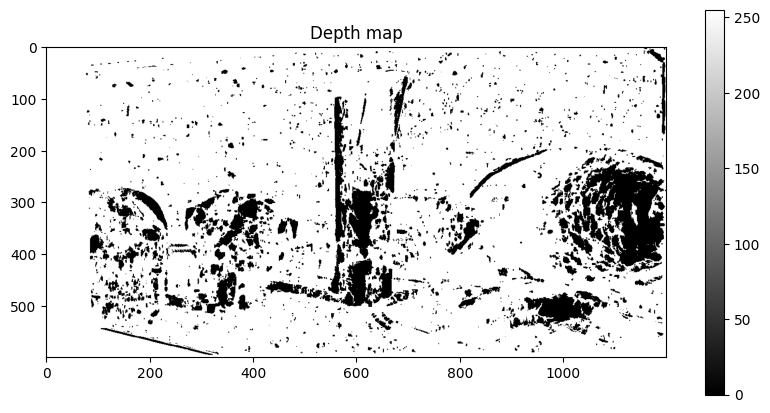

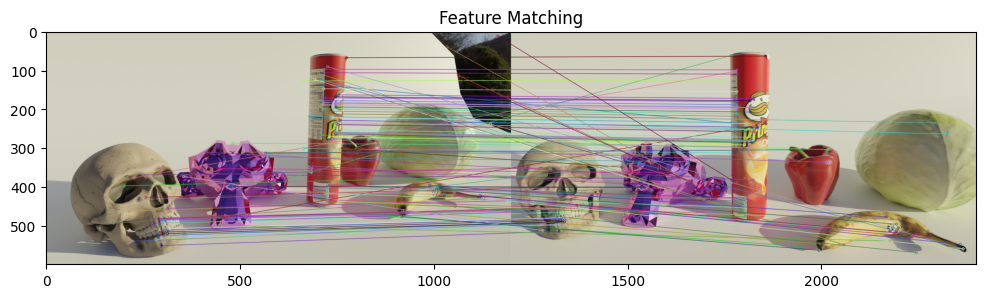

True

In [334]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 讀取左右影像
img1 = cv2.imread("./task1/b.png")  # 左影像
img2 = cv2.imread("./task1/a.png")  # 右影像

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 2. 使用 SIFT 檢測特徵點並計算描述子
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# 3. 使用 FLANN 進行特徵匹配
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # 搜索次數，影響準確性和速度

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 4. 過濾匹配點 (Lowe's ratio test)
good_matches = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.float32(pts1).reshape(-1, 1, 2)
pts2 = np.float32(pts2).reshape(-1, 1, 2)

# 相機內參矩陣 K (示例數據，請替換為你的實際 K)
K = np.array([
    [600, 0, 600],  # fx,  0, cx
    [0, 600, 300],  #  0, fy, cy
    [0, 0, 1]       #  0,  0,  1
])

# 5. 計算 Fundamental Matrix F
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# 計算 Essential Matrix
E = K.T @ F @ K

# SVD 分解 E 矩陣
U, S, Vt = np.linalg.svd(E)

# 平移向量 T 是 U 的最後一列 (或者 Vt 的最後一行)
T = U[:, 2]  # 取 U 的第三列

# 計算基線距離 B (T 的範數)
B = np.linalg.norm(T)

print(f"基線距離 B: {B:.6f} 米")

# 過濾內點
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]
print(f"Fundametal: {E}")

# 6. 極線校正 (Epipolar Rectification)
h1, w1, c = img1.shape
h2, w2, c = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imgSize=(w1, h1))

img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))

print("Estimated H1 and H2 as", H1, H2)

set1_rectified = cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), H1).reshape(-1,2)
set2_rectified = cv2.perspectiveTransform(pts2.reshape(-1, 1, 2), H2).reshape(-1,2)

img1_rectified_draw = img1_rectified.copy()
img2_rectified_draw = img2_rectified.copy()

H2_T_inv =  np.linalg.inv(H2.T)
H1_inv = np.linalg.inv(H1)
F_rectified = np.dot(H2_T_inv, np.dot(F, H1_inv))

lines1_rectified, lines2_recrified = getEpipolarLines(set1_rectified, set2_rectified, F_rectified, img1_rectified, img2_rectified, True)

# img1_rectified_new, H1_updated = warp_perspective_with_full_view(img1, H1)
# img2_rectified_new, H2_updated = warp_perspective_with_full_view(img1, H2)
# img1_rectified_new = cv2.resize(img1_rectified_new, (img2_rectified_new.shape[1], img2_rectified_new.shape[0]))
# print(img1_rectified_new.shape)
# print(img2_rectified_new.shape)




# 7. 使用 StereoBM 計算視差圖
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
# 建立 StereoSGBM 物件
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=64, 
#     blockSize=9,
#     P1=8 * 3 * 9**2, 
#     P2=32 * 3 * 9**2,
#     disp12MaxDiff=1, 
#     uniquenessRatio=10, 
#     speckleWindowSize=100, 
#     speckleRange=32
# )
disparity = stereo.compute(img2_rectified[:, :, 0], img1_rectified[:, :, 0])
H2_inv =  np.linalg.inv(H2)
disparity = cv2.warpPerspective(disparity, H2_inv, (w1, h1))
disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
# print(disparity)

# 取得焦距 f (一般取 fx)
f = K[0, 0]  # 取 K[0,0] 作為 f (fx)
# 避免除以 0，將視差為 0 的地方設為極小值
disparity = disparity.astype(np.float32)
disparity[disparity <= 0] = 0.1
print(np.min(disparity))  # 這次應該會是 0.1

# 計算深度圖
depth_map = (f * B) / disparity
print(np.max(depth_map ))

# 可選：將深度圖正規化到 0-255（僅用於顯示）
depth_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_uint8 = np.uint8(depth_normalized)


# plt.imshow(img1_retified_new[:, :, 0])


# 8. 顯示視差圖
plt.figure(figsize=(10, 5))
plt.imshow(depth_uint8, cmap='gray')
plt.colorbar()
plt.title("Depth map")
plt.show()
cv2.imwrite('depth.png', depth_uint8)

# 9. 顯示匹配結果
match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(match_img[:, :, ::-1])
plt.title("Feature Matching")
plt.show()
cv2.imwrite('matching_result.png', match_img)


In [219]:
from skimage.metrics import structural_similarity as ssim

gt = cv2.imread('./task1/a_gt_depth.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY) / 255.0

####

V2 = cv2.imread('ass1/images/depth_l.png')
V2 = cv2.cvtColor(V2, cv2.COLOR_BGR2GRAY) / 255.0

####

lidar = 255 - cv2.imread('./task1/a_lidar.png')
lidar = cv2.cvtColor(lidar, cv2.COLOR_BGR2GRAY) / 255.0

MAE_uncal = np.mean(np.abs((depth_uint8/255.0) - gt))
MAE_V2 = np.mean(np.abs(V2 - gt))
MAE_lidar = np.mean(np.abs(lidar - gt))

In [220]:
abs_error_uncal = np.abs((depth_uint8/255.0) - gt)
abs_error_v2 = np.abs(V2 - gt)
abs_error_lidar = np.abs(lidar - gt)

Text(0.5, 1.0, 'Absolute Error Map')

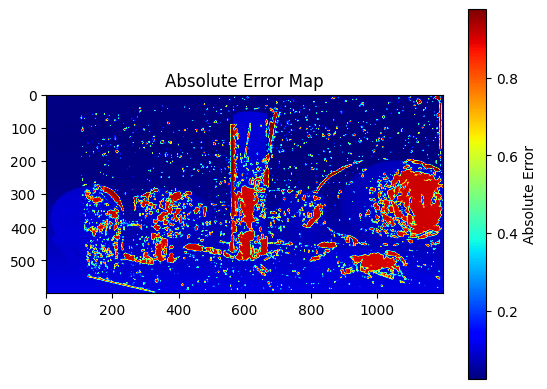

In [221]:
plt.imshow(abs_error_uncal, cmap='jet')
plt.colorbar(label='Absolute Error')
plt.title('Absolute Error Map')

Text(0.5, 1.0, 'Absolute Error Map')

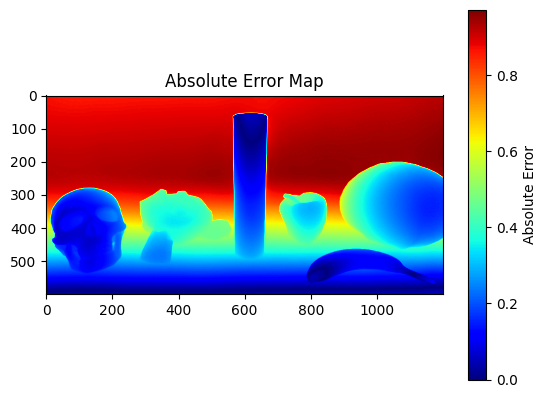

In [222]:
plt.imshow(abs_error_v2, cmap='jet')
plt.colorbar(label='Absolute Error')
plt.title('Absolute Error Map')

Text(0.5, 1.0, 'Absolute Error Map')

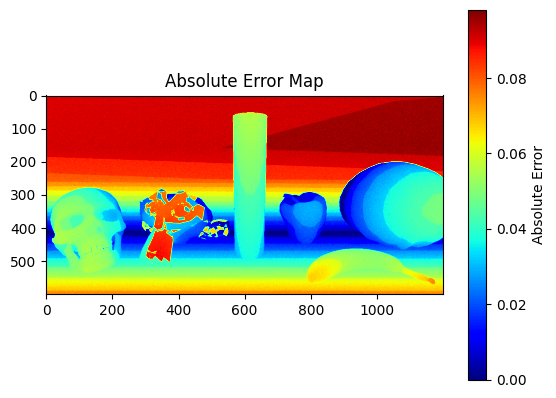

In [223]:
plt.imshow(abs_error_lidar, cmap='jet')
plt.colorbar(label='Absolute Error')
plt.title('Absolute Error Map')

In [224]:
MAE_uncal

0.1816542156862745

In [225]:
MAE_V2

0.541970250544662

In [226]:
MAE_lidar

0.06241397603485839

In [232]:
# 計算 SSIM
ssim_value, ssim_map = ssim(lidar, gt, data_range=255, full=True)

In [229]:
ssim_value

0.9880785527099087

In [231]:
ssim_value

0.9438971550893148

In [233]:
ssim_value

0.9994432273164308

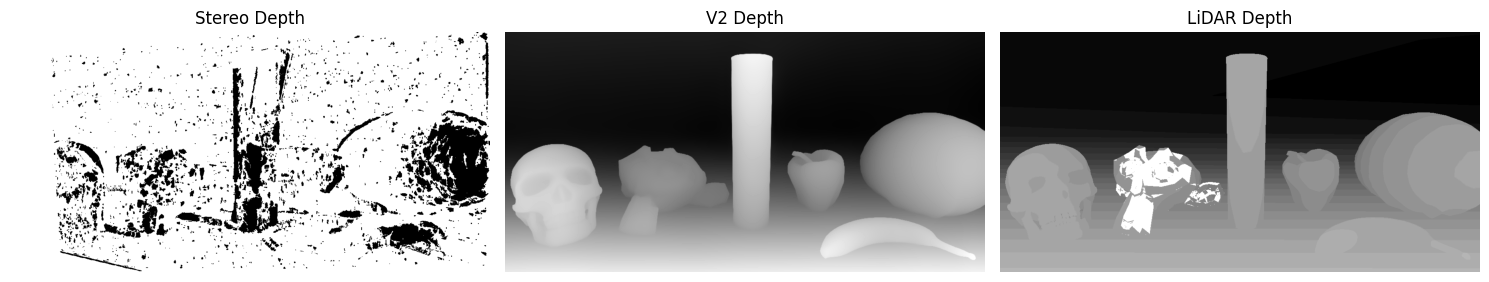

In [252]:
# Create a single figure with three images in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for each image
titles = ["Stereo Depth", "V2 Depth", "LiDAR Depth"]

# Images to display
images = [depth_uint8/255.0, V2, lidar]

# Display each image
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis("off")

# Show the combined figure
plt.tight_layout()
plt.show()

fig.savefig('ass1/images/3_depth.png', dpi=300, bbox_inches='tight')

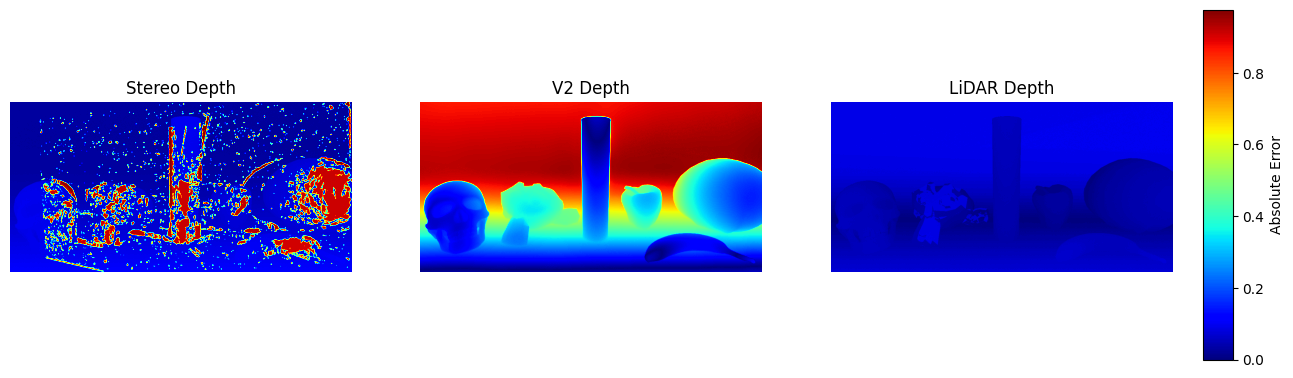

In [250]:
# Create a single figure with three images in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for each image
titles = ["Stereo Depth", "V2 Depth", "LiDAR Depth"]

# Images to display
images = [abs_error_uncal, abs_error_v2, abs_error_lidar]

# Determine the min and max values across all images for consistent color scaling
vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

# Display each image and store the first mappable object for the colorbar
im = None
for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")

# Add a single colorbar to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, label="Absolute Error")

# Show the figure
plt.show()

fig.savefig('ass1/images/L1.png', dpi=300, bbox_inches='tight')

# Task2: Photometric Stereo  

1. Generate 12 visualization results by different lighting directions using the provided normal map, albedo map, and lighting matrix.
   
2. Extract the \( p \) and \( q \) gradients from the normal map, and reconstruct the depth map using multiple integration methods (e.g., simple integration, global least-squares, and Poisson integration). Compare the stability and reconstruction accuracy of the different integration methods in the presence of noise.

3. Analyze how potential errors in the normal and albedo maps (e.g., normalization issues, data range inconsistencies, noise) can propagate through the rendering process.
Explain how these errors affect the final reconstructed images, and discuss strategies that might mitigate their impact.

---
#### Mathematical Principles of Integration Methods  

**- Simple Integration**  
- Directly accumulates gradients **$p$** and **$q$** along the **rows (x-direction)** and **columns (y-direction)** to estimate depth.  
- Given:  
  - $ p = -\frac{\partial z}{\partial x} $,  
  - $ q = -\frac{\partial z}{\partial y} $,  
- The depth **$z(x, y)$** can be obtained via numerical integration:

  $$ z(x, y) = \int -p(x, y) dx + \int -q(x, y) dy $$



**- Global Least-Squares Integration**  
- Solves the **Poisson equation** using a **variational approach** to minimize errors between the estimated depth **$z(x, y)$** and the given gradients **$p$** and **$q$**.

- The **Poisson equation**:

  $$ \frac{\partial^2 z}{\partial x^2} + \frac{\partial^2 z}{\partial y^2} = \frac{\partial p}{\partial x} + \frac{\partial q}{\partial y} $$

- It can also be written in terms of **divergence**:

  $$ \nabla^2 z = \text{div}(p, q) $$

  where:

  $$ \text{div}(p, q) = \frac{\partial p}{\partial x} + \frac{\partial q}{\partial y} $$

- Uses **Fast Fourier Transform (FFT)** for efficient numerical solution.



**- Poisson Integration**  
- Directly solves the **Poisson equation**:

  $$ \nabla^2 z = \frac{\partial p}{\partial x} + \frac{\partial q}{\partial y} $$

- Uses **Jacobi Iteration** as a numerical solver.

---







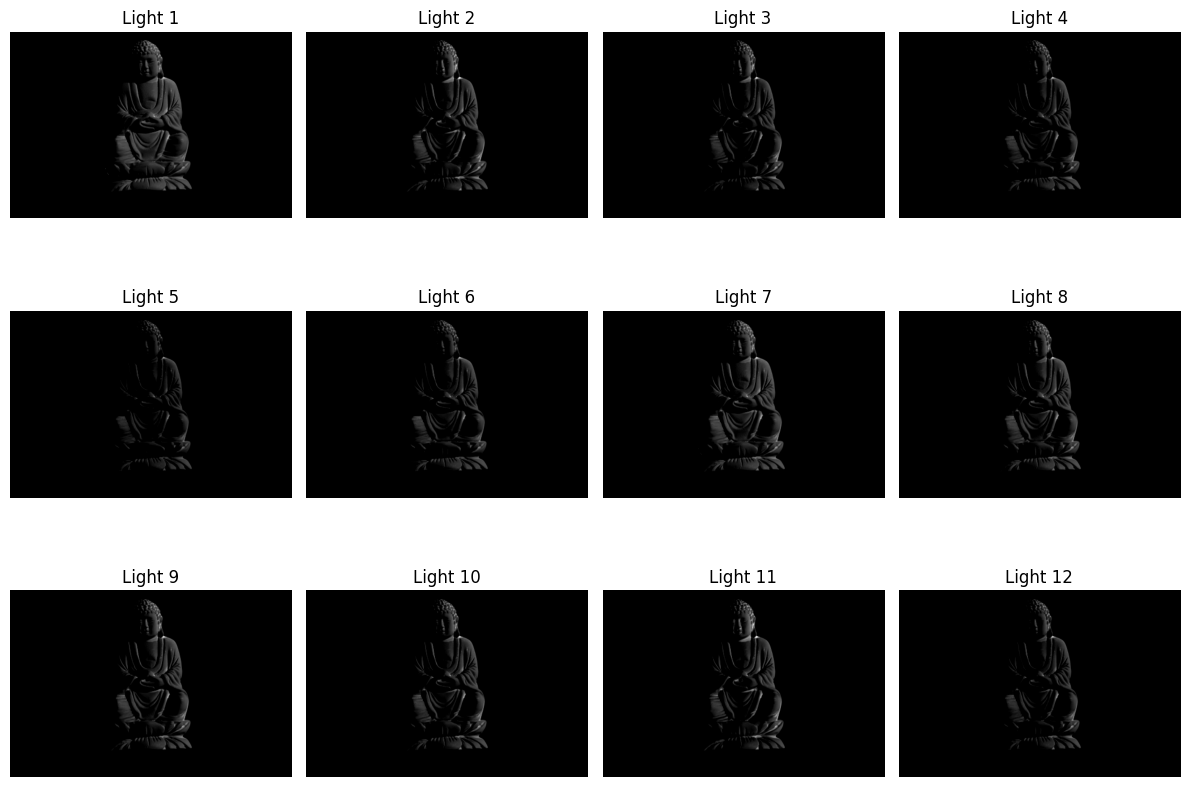

In [325]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import re

# Load images
normal_map = cv2.imread("./task2/normal_normalized.png") / 255.0 * 2 - 1
albedo_map = cv2.imread("./task2/albedo.png") / 255.0

# Ensure the albedo map has the correct shape
if albedo_map.ndim == 2:  # Convert grayscale to 3-channel format
    albedo_map = np.expand_dims(albedo_map, axis=-1)

# Read YAML file
with open("./task2/LightMatrix.yml", 'r') as file:
    data = yaml.safe_load(file)

light_directions = np.array(data['data']).reshape(12, 3)
# Generate 12 visualizations
visualizations = []
for i, light_dir in enumerate(light_directions):
    light_dir = light_dir / np.linalg.norm(light_dir)  # Normalize light direction

    # Compute shading (dot product of normal and light direction)
    shading = np.maximum(np.sum(normal_map * light_dir, axis=-1, keepdims=True), 0)

    # Apply shading to albedo
    shaded_image = (shading * albedo_map).clip(0, 1)

    # Convert to 8-bit image
    shaded_image = (shaded_image * 255).astype(np.uint8)

    visualizations.append(shaded_image)

# Display results
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(visualizations[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Light {i+1}")
    ax.axis("off")

plt.tight_layout()
# 儲存圖片
# fig.savefig("./task2/12_images.png", dpi=300, bbox_inches="tight")
plt.show()

## Using 12 images to calculate the normal map 

True

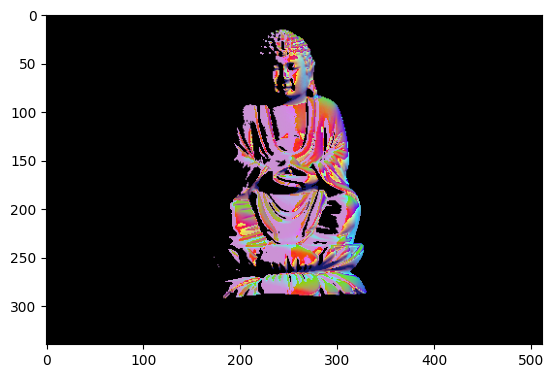

In [311]:
gray_imgs = []
for img in visualizations:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_imgs.append(img)
    
I = np.stack(gray_imgs, axis=-1)

# 求解法向量
S_inv = np.linalg.pinv(light_directions)  # Moore-Penrose 逆矩陣 (S^T S)^-1 S^T
N = np.einsum('ij,hwj->hwi', S_inv, I)  # 進行矩陣乘法 (H, W, 3)

# 正規化
norm = np.linalg.norm(N, axis=-1, keepdims=True)
N /= (norm + 1e-8)

# 轉換為 RGB 格式的 normal map
normal_map2 = (N * 255).astype(np.uint8)

plt.imshow(normal_map2)
# cv2.imwrite('./task2/new_normal_map_RGB.png', normal_map2[:, :, ::-1])

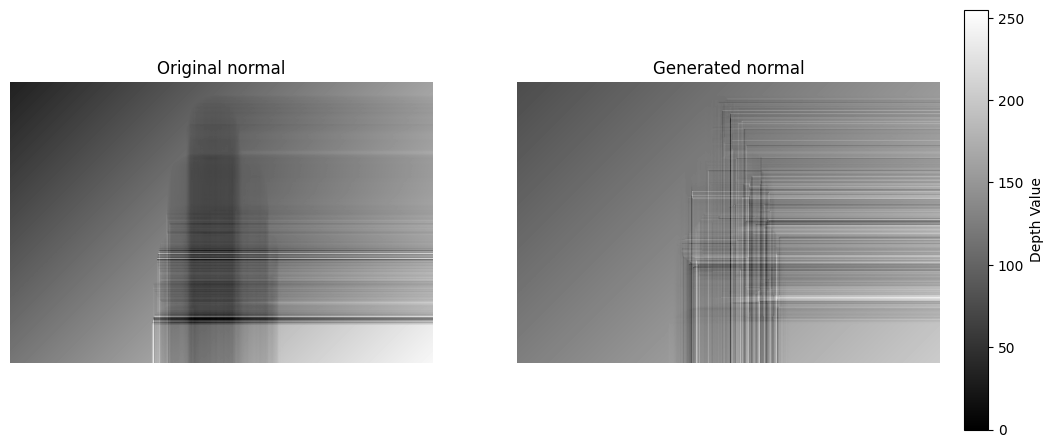

In [333]:
def simple_integration(normal_map):
    h, w, _ = normal_map.shape
    normal_map = normal_map.astype(np.float32) / 255.0 * 2 - 1  # Normalize to range [-1, 1]

    # Extract normal components
    Nx, Ny, Nz = normal_map[..., 0], normal_map[..., 1], normal_map[..., 2]
    
    # Normalize normal vectors to unit length
    norm = np.sqrt(Nx**2 + Ny**2 + Nz**2) + 1e-6  # Avoid division by zero
    Nx /= norm
    Ny /= norm
    Nz /= norm

    # Compute depth gradients
    dZdx = Nx / Nz
    dZdy = Ny / Nz

    # Integrate depth using cumulative sum
    Zx = np.cumsum(dZdx, axis=1)  # Integrate along x-direction
    Zy = np.cumsum(dZdy, axis=0)  # Integrate along y-direction

    depth = (Zx + Zy) / 2  # Average the two integrations to reduce bias
    
    return depth

# 計算深度圖
normal_map = cv2.imread('./task2/normal_normalized.png')
normal_map = cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB)
# Convert normal map to depth
depth_map = simple_integration(normal_map)
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

# 計算深度圖
normal_map2 = cv2.imread('./task2/new_normal_map.png')
normal_map2 = cv2.cvtColor(normal_map2, cv2.COLOR_BGR2RGB)

# Convert normal map to depth
depth_map2 = simple_integration(normal_map2)
depth_map2 = cv2.normalize(depth_map2, None, 0, 255, cv2.NORM_MINMAX)

# 設定畫布
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 設定顏色範圍
vmin, vmax = min(depth_map.min(), depth_map2.min()), max(depth_map.max(), depth_map2.max())

# 顯示第一張深度圖
im1 = axes[0].imshow(depth_map, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title("Original normal")
axes[0].axis("off")

# 顯示第二張深度圖
im2 = axes[1].imshow(depth_map2, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title("Generated normal")
axes[1].axis("off")

# 調整 color bar，使其不影響版面
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Depth Value")

plt.subplots_adjust(right=0.9)  # 確保圖像不被擠壓
fig.savefig("./task2/simple_integration.png", dpi=300, bbox_inches="tight")
plt.show()

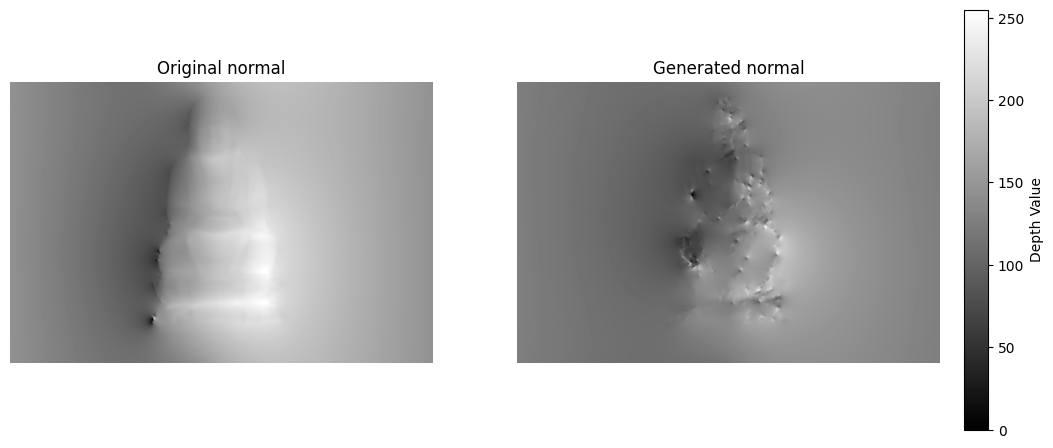

In [332]:
def global_least_squares(normal_map):
    h, w, _ = normal_map.shape
    normal_map = normal_map.astype(np.float32) / 255.0 * 2 - 1  # Normalize to [-1, 1]

    # Extract and normalize normal vectors
    Nx, Ny, Nz = normal_map[..., 0], normal_map[..., 1], normal_map[..., 2]
    norm = np.sqrt(Nx**2 + Ny**2 + Nz**2) + 1e-6  # Avoid division by zero
    Nx /= norm
    Ny /= norm
    Nz /= norm

    # Compute gradient divergence (Poisson equation right-hand side)
    dZdx = Nx / Nz
    dZdy = Ny / Nz
    div_N = np.gradient(dZdx, axis=1) + np.gradient(dZdy, axis=0)  # Compute divergence ∂²Z/∂x² + ∂²Z/∂y²

    # Apply 2D FFT
    fft_div_N = np.fft.fft2(div_N)

    # Generate frequency grid
    kx = np.fft.fftfreq(w).reshape(1, -1)
    ky = np.fft.fftfreq(h).reshape(-1, 1)
    kx, ky = np.meshgrid(kx, ky)  # Generate 2D frequency coordinates
    denom = (4 * np.pi**2 * (kx**2 + ky**2))

    # Avoid division by zero at the DC component (set it to zero)
    denom[0, 0] = 1  # To prevent zero division (this will later be ignored)
    
    # Solve Poisson equation in frequency domain
    fft_Z = fft_div_N / denom

    # Set DC component (global offset) to zero
    fft_Z[0, 0] = 0

    # Inverse FFT to get depth map
    depth = np.fft.ifft2(fft_Z).real  # Take real part

    # Normalize depth for visualization
    depth -= depth.min()
    depth /= depth.max()

    return depth

# 計算深度圖
normal_map = cv2.imread('./task2/normal_normalized.png')
normal_map = cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB)
# Convert normal map to depth
depth_map = global_least_squares(normal_map)
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

# 計算深度圖
normal_map2 = cv2.imread('./task2/new_normal_map.png')
normal_map2 = cv2.cvtColor(normal_map2, cv2.COLOR_BGR2RGB)

# Convert normal map to depth
depth_map2 = global_least_squares(normal_map2)
depth_map2 = cv2.normalize(depth_map2, None, 0, 255, cv2.NORM_MINMAX)

# 設定畫布
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 設定顏色範圍
vmin, vmax = min(depth_map.min(), depth_map2.min()), max(depth_map.max(), depth_map2.max())

# 顯示第一張深度圖
im1 = axes[0].imshow(depth_map, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title("Original normal")
axes[0].axis("off")

# 顯示第二張深度圖
im2 = axes[1].imshow(depth_map2, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title("Generated normal")
axes[1].axis("off")

# 調整 color bar，使其不影響版面
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Depth Value")

plt.subplots_adjust(right=0.9)  # 確保圖像不被擠壓
fig.savefig("./task2/global_least_squares.png", dpi=300, bbox_inches="tight")
plt.show()

Jacobi iteration converged after 4916 iterations.


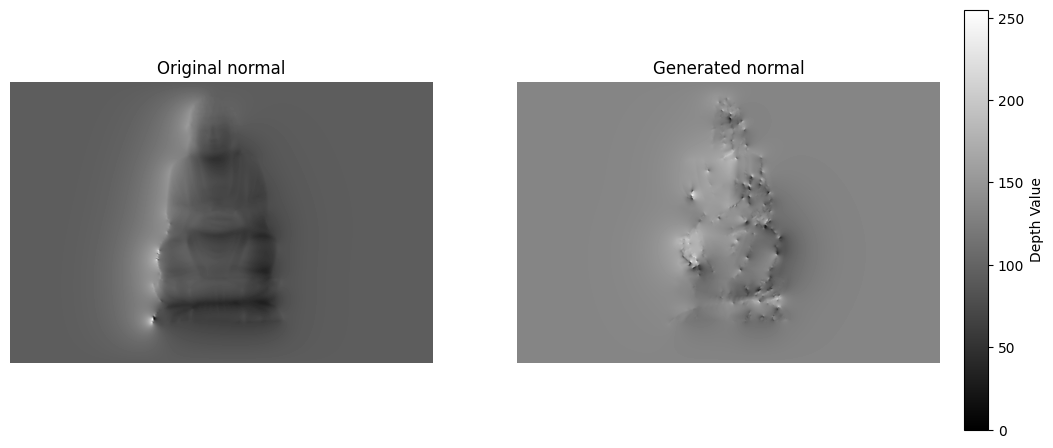

In [331]:
def poisson_jacobi(normal_map, num_iters=5000, tol=1e-4):
    h, w, _ = normal_map.shape
    normal_map = normal_map.astype(np.float32) / 255.0 * 2 - 1  # Normalize to [-1, 1]

    # Extract normal vectors and normalize
    Nx, Ny, Nz = normal_map[..., 0], normal_map[..., 1], normal_map[..., 2]
    norm = np.sqrt(Nx**2 + Ny**2 + Nz**2) + 1e-6  # Avoid division by zero
    Nx /= norm
    Ny /= norm
    Nz /= norm

    # Compute divergence (Poisson equation right-hand side)
    dZdx = Nx / Nz
    dZdy = Ny / Nz
    div_N = np.gradient(dZdx, axis=1) + np.gradient(dZdy, axis=0)

    # Initialize depth map with zeros
    Z = np.zeros((h, w), dtype=np.float32)
    
    # Jacobi iteration for solving Poisson equation
    for iteration in range(num_iters):
        Z_new = np.copy(Z)
        
        # Update each pixel using Jacobi iteration formula
        Z_new[1:-1, 1:-1] = 0.25 * (Z[2:, 1:-1] + Z[:-2, 1:-1] + Z[1:-1, 2:] + Z[1:-1, :-2] - div_N[1:-1, 1:-1])

        # Compute error (stopping condition)
        error = np.linalg.norm(Z_new - Z, ord='fro') / np.linalg.norm(Z, ord='fro') if np.linalg.norm(Z, ord='fro') > 0 else np.inf
        
        Z = Z_new
        
        if error < tol:
            print(f"Jacobi iteration converged after {iteration+1} iterations.")
            break

    # Normalize depth for visualization
    Z -= Z.min()
    Z /= Z.max()

    return Z

# 計算深度圖
normal_map = cv2.imread('./task2/normal_normalized.png')
normal_map = cv2.cvtColor(normal_map, cv2.COLOR_BGR2RGB)
# Convert normal map to depth
depth_map = poisson_jacobi(normal_map)
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

# 計算深度圖
normal_map2 = cv2.imread('./task2/new_normal_map.png')
normal_map2 = cv2.cvtColor(normal_map2, cv2.COLOR_BGR2RGB)

# Convert normal map to depth
depth_map2 = poisson_jacobi(normal_map2)
depth_map2 = cv2.normalize(depth_map2, None, 0, 255, cv2.NORM_MINMAX)

# 設定畫布
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 設定顏色範圍
vmin, vmax = min(depth_map.min(), depth_map2.min()), max(depth_map.max(), depth_map2.max())

# 顯示第一張深度圖
im1 = axes[0].imshow(depth_map, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title("Original normal")
axes[0].axis("off")

# 顯示第二張深度圖
im2 = axes[1].imshow(depth_map2, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title("Generated normal")
axes[1].axis("off")

# 調整 color bar，使其不影響版面
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Depth Value")

plt.subplots_adjust(right=0.9)  # 確保圖像不被擠壓
fig.savefig("./task2/poisson_jacobi.png", dpi=300, bbox_inches="tight")
plt.show()